# Modelling Aerofoil Sections

In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

***
## Introduction

One of the first tasks undertaken in aeronautical design work is the selection of an appropriate aerofoil geometry.
Classic approaches generate geometry procedurally, and then determine the aerodynamic properties of the resulting shape.
Modern methods require that designers first specify a target pressure distribution, which can then be mapped to a corresponding shape through *inverse design*.
CARPy supports classic aerofoil shaping through:

1. `NewAerofoil`: a class of methods for generating non-dimensional aerofoil geometries from.
2. `Aerofoil`: an object for communicating non-dimensional aerofoil geometry.

After an aerofoil shape is selected, CARPy users can obtain aerodynamic predictions using:

3. `AeroSolution`: an object capturing basic performance coefficients of aerofoil sections.

Inverse design methods are not supported at this time.



***
## 1) `NewAerofoil` methods

Start with relevant imports

In [2]:
from carpy.geometry import NewAerofoil

public_methods = [x for x in dir(NewAerofoil) if not x.startswith("__")]
print(public_methods)

['from_file', 'from_method', 'from_url']


We'll demonstrate how each of the `NewAerofoil` methods can be used to generate non-dimensional aerofoil geometry below.

#### `from_path`

Of course in a jupyter notebook, the below code won't work if you don't have the correct file in the correct place on your machine.
You'll have to take our word when we say this works:

```
# Read aerofoil coordinates from a local file
>>> aerofoil_0 = NewAerofoil.from_path("C:\\Users\\Public\\Documents\\seligdatfile.txt")

# Visualise it!
>>> aerofoil_0.show()
```
<!-- *the result is supposed to look like what's rendered below...*
![Aerofoil as loaded from path](./images/ndaerofoil_frompath_show.png) -->

#### `from_method.NACA`

This attribute contains the sub-attribute `NACA`, from which 4-digit, 5-digit, and 16 series aerofoils can be generated given the relevant NACA aerofoil code:

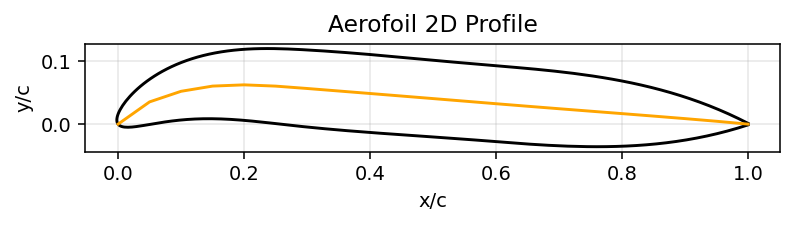

In [3]:
# Generate a NACA (5-digit modified series) aerofoil
aerofoil_1 = NewAerofoil.from_method.NACA("64012-56")

# Visualise it!
aerofoil_1.show()

#### `from_url`

Perhaps the most convenient method, this exploit's a computer's internet connection to quickly read aerofoil coordinates from online databases:

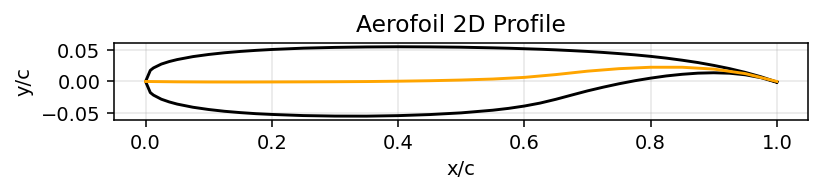

In [4]:
# Create an aerofoil object from an online URL pointing to a .dat file of Selig or Lednicer format coordinates 
aerofoil_2 = NewAerofoil.from_url(url="http://airfoiltools.com/airfoil/lednicerdatfile?airfoil=whitcomb-il")

# Visualise it!
aerofoil_2.show()

Note that non-dimensional aerofoil geometry is *supposed* to place the point of highest curvature as the leading edge, and the half-way point between upper and lower trailing edge surfaces as the trailing edge.
In the case of this Whitcomb aerofoil, this convention is not adhered to at the trailing edge!

***
## 2) `Aerofoil` objects

The `NewAerofoil` methods spawn, as you might guess already, `Aerofoil` or non-dimensional aerofoil objects.
You can learn more about an aerofoil's non-dimensional area (scales with the square of the reference chord length) and the aerofoil's non-dimensional wetted perimeter (scales linearly with reference chord length):

In [5]:
# By default (and definition), the reference chord length of non-dimensional aerofoils is 1

from carpy.utility import Quantity

chord_length = Quantity(2.4, "m")
print(
    f"aerofoil_1 with a chord of {chord_length} would have "
    f"a wetted perimeter of {aerofoil_1.section.section_props.perimeter * chord_length}, and "
    f"an internal area of {aerofoil_1.section.section_props.area * chord_length ** 2}."
)

aerofoil_1 with a chord of 2.4 m would have a wetted perimeter of 4.981699185182784 m, and an internal area of 0.5840527585130282 m².


Other useful public methods attributable to the geometry of the aerofoils are displayed as follows:

In [6]:
public_attrs = [x for x in dir(aerofoil_1) if not x.startswith("_")]
print(f"{public_attrs=}\n")

print(f"For a chord length of unity:\n {aerofoil_1.le_radius=}\n {aerofoil_1.perimeter=}.")

public_attrs=['coords', 'le_radius', 'perimeter', 'points', 'section', 'show']

For a chord length of unity:
 aerofoil_1.le_radius=0.00879197943292808
 aerofoil_1.perimeter=2.0733079938257752.


***
## 3) `AeroSolution` objects

It is possible to carry out a rudimentary analysis of aerofoil performance in CARPy, returing `AeroSolution` objects.
These can be obtained through:

In [7]:
from carpy.aerodynamics import ThinAerofoil2D  # Thin aerofoil theory
from carpy.aerodynamics import VortexSource2D  # Inviscid panel method

All derivative methods of `AeroSolution` have similar instantiation structures.

#### `ThinAerofoil2D`

In [8]:
# Compute a solution for aerofoil_2 @ alpha=5.0 degrees
solution = ThinAerofoil2D(aerofoil_2, alpha=5 * (3.14159/180), Npanels=100)

public_attrs = [x for x in dir(solution) if not x.startswith("_")]
print(f"{public_attrs=}\n")

print(solution)

public_attrs=['CD', 'CD0', 'CDi', 'CDw', 'CL', 'CY', 'Cl', 'Cm', 'Cn', 'Cni', 'TAS', 'alpha', 'altitude', 'atmosphere', 'beta', 'geometric', 'sections', 'x_cp']

** <carpy.geometry._aerofoils.Aerofoil object at 0x0000025D1C5A7070> **
 CD  =  0.000000    CY  =       NAN    CL  =  0.783943
 CD0 =       NAN    CDi =       NAN    CDw =       NAN
 Cl  =       NAN    Cm  = -0.133728    Cn  =       NAN
 Cli =       NAN    Cmi =       NAN    Cni =       NAN


#### `VortexSource2D`

CARPy does not yet automatically derive useful performance coefficients to the user, however a manual analysis of results is still possible.
For example, NACA 16-series aerofoils are a sub-family of the 1-series aerofoils for which the designed point of minimum pressure in a symmetrical aerofoil (without camber) is 60% of the way behind the leading edge:

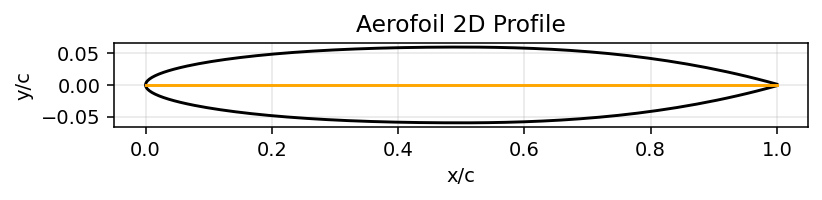

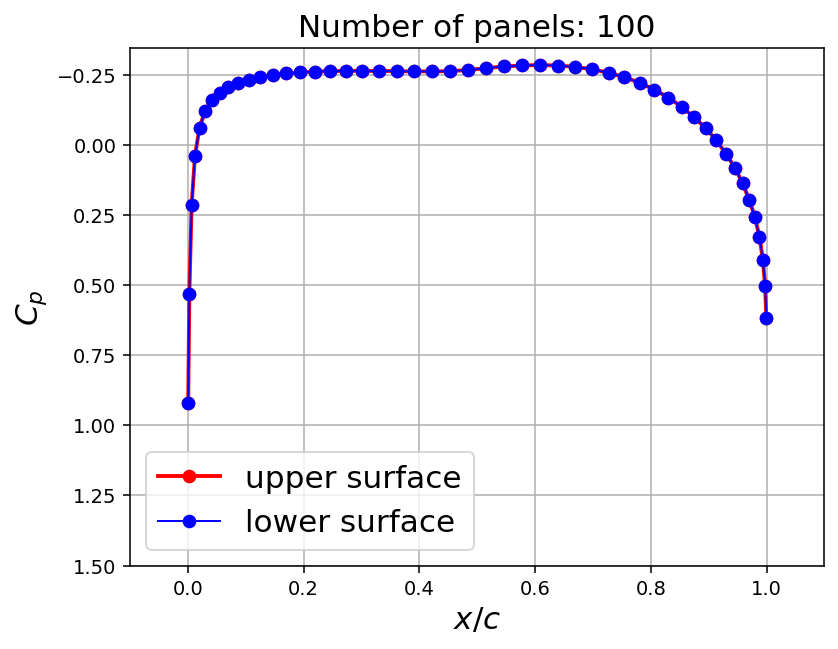

In [9]:
# 16-series aerofoil
aerofoil_3 = NewAerofoil.from_method.NACA("16-012")
aerofoil_3.show()

# Compute a solution for aerofoil_2 @ alpha=0.0 degrees
solution = VortexSource2D(aerofoil=aerofoil_3, alpha=0, Npanels=100)
solution.show_Cp()

It should be possible using the inviscid panel method to produce estimates of a geometry's centre of pressure.
Estimates of other coefficients such as lift and (form) drag are possibly subject to error as the method does not yet include wake panels, and further work is required to verify the results of this method.